<a href="https://colab.research.google.com/github/nitaifingerhut/cs236608/blob/master/project/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Reclab installation. This may take a minute or two
!pip install pybind11
!pip install reclab[recommenders]
!cp /usr/local/lib/python3.7/dist-packages/wpyfm/pyfm.cpython-36m-x86_64-linux-gnu.so /usr/local/lib/python3.7/dist-packages/wpyfm/pyfm.so
!git clone https://github.com/berkeley-reclab/RecLab /usr/local/lib/python3.7/dist-packages/reclab2
!cp -a /usr/local/lib/python3.7/dist-packages/reclab2/reclab/recommenders/. /usr/local/lib/python3.7/dist-packages/reclab/recommenders/

     |████████████████████████████████| 211 kB 15.9 MB/s 
     |████████████████████████████████| 45 kB 1.9 MB/s 
     |████████████████████████████████| 824 kB 21.5 MB/s 
  Created wheel for reclab: filename=RecLab-0.1.2-py3-none-any.whl size=60733 sha256=24874ee23a57e57e2d661aa821de51bc073c8fa929dadbed9b2a2dfe9450ffc2
  Stored in directory: /root/.cache/pip/wheels/39/7b/c4/3ead22ed36019505396283006cea7af209322c971c291680c1
  Created wheel for wpyfm: filename=wpyfm-0.1.9-py3-none-any.whl size=175097 sha256=2f9d9f2bc977fde900200d0ed7b49a9d6637c65e9a5b96a732989d8055981d9d
  Stored in directory: /root/.cache/pip/wheels/f6/e7/c1/0204800051d90a6abcfc63941f6aab399f157ccd3f63012a36
Successfully built reclab wpyfm
Cloning into '/usr/local/lib/python3.7/dist-packages/reclab2'...
remote: Enumerating objects: 5123, done.
remote: Counting objects: 100% (249/249), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 5123 (delta 145), reused 156 (delta 84), pack-reused 4874
Receiv

In [2]:
import scipy.sparse
import wpyfm
from reclab.recommenders.libfm import LibFM

class LibFM_MLHB(LibFM):
  def _predict(self, user_item):  # noqa: D102
    # Create a test_inputs array that can be parsed by our output function.
    test_inputs = []
    data = []
    row_col = [[], []]
    for row, (user_id, item_id, rating_context) in enumerate(user_item):
        user_features = self._users[user_id]
        item_features = self._items[item_id]
        row_col[0].append(row)
        row_col[1].append(user_id)
        data.append(1)
        for i, feature in enumerate(user_features):
            row_col[0].append(row)
            row_col[1].append(self._max_num_users + i)
            data.append(feature)
        row_col[0].append(row)
        row_col[1].append(self._max_num_users + len(user_features) + item_id)
        data.append(1)
        for i, feature in enumerate(item_features):
            row_col[0].append(row)
            row_col[1].append(self._max_num_users + len(user_features) +
                              self._max_num_items + i)
            data.append(feature)
        for i, feature in enumerate(rating_context):
            row_col[0].append(row)
            row_col[1].append(self._max_num_users + len(user_features) +
                              self._max_num_items + len(item_features) + i)
            data.append(feature)

    test_inputs = scipy.sparse.csr_matrix((data, row_col),
                                          shape=(len(user_item), self._num_features))
    test_data = wpyfm.Data(test_inputs, np.zeros(test_inputs.shape[0]), has_xt=self._has_xt)
    predictions = self._model.predict(test_data)

    return predictions

  def reset(self, users=None, items=None, ratings=None):  # noqa: D102
    rating_inputs = scipy.sparse.csr_matrix((0, self._num_features))
    rating_outputs = np.empty((0,))
    self._train_data = wpyfm.Data(rating_inputs, rating_outputs, has_xt=self._has_xt)
    super().reset(users, items, ratings)
    self._model.train(self._train_data)

In [3]:
import numpy as np
import reclab
from reclab.environments import Topics
from reclab.recommenders.libfm import LibFM
from reclab.recommenders import RandomRec, TopPop, KNNRecommender, Autorec

NUM_USERS         = 100
NUM_ITEMS         = 100
NUM_TOPICS        = 10
RATING_FREQ       = 0.2
NUM_INIT_RATINGS  = NUM_USERS * NUM_ITEMS // 5

env_params = {
    'num_topics':       NUM_TOPICS,
    'num_users':        NUM_USERS,
    'num_items':        NUM_ITEMS,
    'rating_frequency': RATING_FREQ,
    'num_init_ratings': NUM_INIT_RATINGS,
}

env = Topics(**env_params)

SEED = 42

env.seed(SEED)

NUM_USER_FEATURES   = 0
NUM_ITEM_FEATURES   = 0
NUM_RATING_FEATURES = 0

rec_params = {
    'num_user_features':    NUM_USER_FEATURES,
    'num_item_features':    NUM_ITEM_FEATURES,
    'num_rating_features':  NUM_RATING_FEATURES,
    'max_num_users':        NUM_USERS,
    'max_num_items':        NUM_ITEMS,
    'seed':                 SEED,
}

recommender = LibFM_MLHB(**rec_params)

In [4]:
def RMSE_func(env, recommender):
  true_ratings = env.dense_ratings
  predicted_ratings = recommender.dense_predictions
  return np.sqrt(np.mean((predicted_ratings-true_ratings)**2))

def ARRI_func(env, recommender):
  all_users = env.users
  recommendations, _ = recommender.recommend(all_users, 1)
  true_ratings = env.dense_ratings
  return np.mean(true_ratings[np.arange(len(all_users)), np.squeeze(recommendations)])

In [5]:
from tqdm import tqdm

def simulation(env, recommender, steps, rpu, retrain=True, callbacks=None, reset=True, seed=0):
  if reset:
    env.seed(seed)
    if hasattr(env, '_topic_change'):
      temp = env._topic_change # Specificaly for topics.
      env._topic_change = 0
      #items, users, ratings = env.reset()  # Wrong order of return values (manorz, Jan 01)
      users, items, ratings = env.reset()
      env._topic_change = temp
    elif hasattr(env, '_affinity_change '):
      temp = env._affinity_change  # Specificaly for latent factor.
      env._affinity_change = 0
      # items, users, ratings = env.reset()
      users, items, ratings = env.reset()
      env._affinity_change = temp
    else:
      # items, users, ratings = env.reset()
      users, items, ratings = env.reset()
    
    recommender.reset(items, users, ratings)

  results = None
  if callbacks is not None:
    results = [[] for _ in callbacks]
    
  for i in tqdm(range(steps)):
    if callbacks is not None:
      for j, callback in enumerate(callbacks):
        res = callback(env, recommender)
        results[j].append(res)

    online_users = env.online_users
    recommendations, predicted_ratings = recommender.recommend(online_users, rpu)
    _, _, ratings, _ = env.step(recommendations)
    recommender.update(ratings=ratings)

    if retrain and hasattr(recommender, '_model'):
        recommender._model.train(recommender._train_data) # Specificaly for libfm.
  return results

In [6]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

def plot_graphs(*lists, title, legend=False, label=None, show=False, save=False):
  fig, ax = plt.subplots()
  for i, l in enumerate(lists):
    ax.plot(
        np.arange(len(l)),
        l,
        '.-',
        label=(str(i+1) if label is None else label[i])
    )
  ax.set_xlabel(r'$timestep$')
  ax.set_title(title)
  if legend:
    ax.legend()
  if save:
    plt.savefig(title + '.png')
  if show:
    plt.show()
  else:
    plt.close()

In [7]:
# import pandas as pd
# import re

# def experiment(env_params, recommender, steps, repeats, rpu, retrain=True, callbacks=None, reset=True, **kwargs):
#   metrics_names = [c.__name__ for c in callbacks]
#   metrics_names = [c[:-5] for c in metrics_names if c.endswith('_func')]
#   cols_names = metrics_names + ['REPEAT']
  
#   if len(kwargs) != 0:
#     k = list(kwargs.keys())[0]
#     v = list(kwargs.values())[0]
#     print(f"{k}: {v}")
#     cols_names.append(k.upper())
  
#   res_df = pd.DataFrame(columns=cols_names)

#   if len(kwargs) != 0:
#     for vv in v:
#       env_params[k] = vv
#       env = Topics(**env_params)
#       for r in range(repeats):
#         print(f'[I] - running simulation with {k}={vv}, repeat {r}')
#         _res = simulation(env, recommender, steps, rpu, retrain, callbacks, reset, r)
#         _df = pd.DataFrame(columns=cols_names)
#         for i, m in enumerate(metrics_names):
#           _df[m] = _res[i]
#         _df['REPEAT'] = r
#         _df[k.upper()] = vv
#         res_df = pd.concat((res_df, _df), axis=0, ignore_index=True)        
#   else:
#     env = Topics(**env_params)
#     for r in range(repeats):
#       print(f'[I] - running simulation, repeat {r}')
#       _res = simulation(env, recommender, steps, rpu, retrain, callbacks, reset, r)
#       _df = pd.DataFrame(columns=cols_names)
#       for i, m in enumerate(metrics_names):
#         _df[m] = _res[i]
#       _df['REPEAT'] = r
#       res_df = pd.concat((res_df, _df), axis=0, ignore_index=True)
  
#   if len(kwargs) != 0:
#     mean_df = pd.DataFrame(columns=cols_names)
#     for vv in v:
#       print(vv)
#       print(res_df[res_df[k.upper()] == vv].mean(axis=0))
#       mean_df.append(res_df[res_df[k.upper()] == vv].mean(axis=0))
#   else:
#     mean_cols_names = metrics_names
#     mean_df = pd.DataFrame(columns=mean_cols_names)
  
#   return res_df, mean_df

In [8]:
import pandas as pd
import re

def experiment(env_params, recommender, steps, repeats, rpu, retrain=True, callbacks=None, reset=True, **kwargs):
  callbacks_names = [c.__name__ for c in callbacks]
  callbacks_names = [c[:-5] for c in callbacks_names if c.endswith('_func')]

  if len(kwargs) != 0:
    k = list(kwargs.keys())[0]
    v = list(kwargs.values())[0]
    print(f"{k}: {v}")
  
  callbacks_res = {n: {vv: [] for vv in v} for n in callbacks_names}
  print(callbacks_res)

  if len(kwargs) != 0:
    for vv in v:
      env_params[k] = vv
      env = Topics(**env_params)
      for r in range(repeats):
        print(f'[I] - running simulation with {k}={vv}, repeat {r}')
        _res = simulation(env, recommender, steps, rpu, retrain, callbacks, reset, r)
        for i, n in enumerate(callbacks_names):
          callbacks_res[n][vv].append(_res[i])
      
      for i, n in enumerate(callbacks_names):
        callbacks_res[n][vv] = list(np.mean(np.asarray(callbacks_res[n][vv]), axis=0))
    
  return callbacks_res        

In [9]:
STEPS =     100
RPU   =     1
RETRAIN =   True
RESET =     True
CALLBACKS = [RMSE_func, ARRI_func]

RMSE, ARRI = simulation(env, recommender, STEPS, RPU, RETRAIN, CALLBACKS, RESET, SEED)

100%|██████████| 100/100 [00:27<00:00,  3.68it/s]


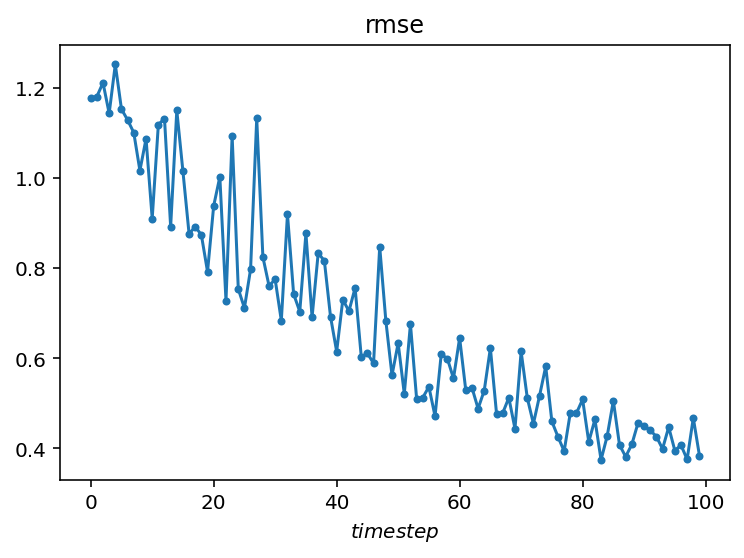

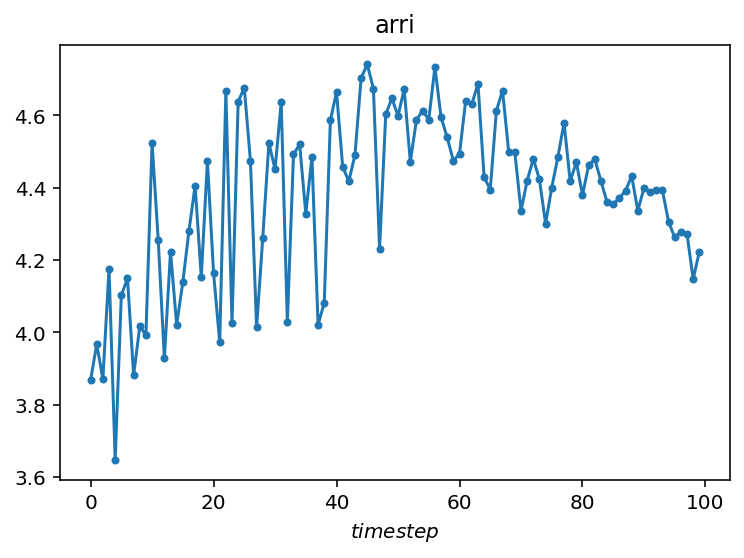

In [10]:
plot_graphs(RMSE, title="rmse", show=True, save=True)
plot_graphs(ARRI, title="arri", show=True, save=True)

In [13]:
REPEATS = 50

res = experiment(env_params, recommender, STEPS, REPEATS, RPU, RETRAIN, CALLBACKS, RESET, topic_change=[0,1,2])

topic_change: [0, 1, 2]
{'RMSE': {0: [], 1: [], 2: []}, 'ARRI': {0: [], 1: [], 2: []}}
[I] - running simulation with topic_change=0, repeat 0


100%|██████████| 100/100 [00:22<00:00,  4.46it/s]


[I] - running simulation with topic_change=0, repeat 1


100%|██████████| 100/100 [00:22<00:00,  4.51it/s]


[I] - running simulation with topic_change=0, repeat 2


100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


[I] - running simulation with topic_change=0, repeat 3


100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


[I] - running simulation with topic_change=0, repeat 4


100%|██████████| 100/100 [00:22<00:00,  4.52it/s]


[I] - running simulation with topic_change=0, repeat 5


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


[I] - running simulation with topic_change=0, repeat 6


100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


[I] - running simulation with topic_change=0, repeat 7


100%|██████████| 100/100 [00:22<00:00,  4.52it/s]


[I] - running simulation with topic_change=0, repeat 8


100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


[I] - running simulation with topic_change=0, repeat 9


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


[I] - running simulation with topic_change=0, repeat 10


100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


[I] - running simulation with topic_change=0, repeat 11


100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


[I] - running simulation with topic_change=0, repeat 12


100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


[I] - running simulation with topic_change=0, repeat 13


100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


[I] - running simulation with topic_change=0, repeat 14


100%|██████████| 100/100 [00:22<00:00,  4.53it/s]


[I] - running simulation with topic_change=0, repeat 15


100%|██████████| 100/100 [00:22<00:00,  4.52it/s]


[I] - running simulation with topic_change=0, repeat 16


100%|██████████| 100/100 [00:22<00:00,  4.51it/s]


[I] - running simulation with topic_change=0, repeat 17


100%|██████████| 100/100 [00:22<00:00,  4.51it/s]


[I] - running simulation with topic_change=0, repeat 18


100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


[I] - running simulation with topic_change=0, repeat 19


100%|██████████| 100/100 [00:22<00:00,  4.46it/s]


[I] - running simulation with topic_change=0, repeat 20


100%|██████████| 100/100 [00:22<00:00,  4.51it/s]


[I] - running simulation with topic_change=0, repeat 21


100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


[I] - running simulation with topic_change=0, repeat 22


100%|██████████| 100/100 [00:22<00:00,  4.53it/s]


[I] - running simulation with topic_change=0, repeat 23


100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


[I] - running simulation with topic_change=0, repeat 24


100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


[I] - running simulation with topic_change=0, repeat 25


100%|██████████| 100/100 [00:22<00:00,  4.52it/s]


[I] - running simulation with topic_change=0, repeat 26


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


[I] - running simulation with topic_change=0, repeat 27


100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


[I] - running simulation with topic_change=0, repeat 28


100%|██████████| 100/100 [00:21<00:00,  4.55it/s]


[I] - running simulation with topic_change=0, repeat 29


100%|██████████| 100/100 [00:22<00:00,  4.52it/s]


[I] - running simulation with topic_change=0, repeat 30


100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


[I] - running simulation with topic_change=0, repeat 31


100%|██████████| 100/100 [00:22<00:00,  4.52it/s]


[I] - running simulation with topic_change=0, repeat 32


100%|██████████| 100/100 [00:21<00:00,  4.56it/s]


[I] - running simulation with topic_change=0, repeat 33


100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


[I] - running simulation with topic_change=0, repeat 34


100%|██████████| 100/100 [00:22<00:00,  4.51it/s]


[I] - running simulation with topic_change=0, repeat 35


100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


[I] - running simulation with topic_change=0, repeat 36


100%|██████████| 100/100 [00:22<00:00,  4.52it/s]


[I] - running simulation with topic_change=0, repeat 37


100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


[I] - running simulation with topic_change=0, repeat 38


100%|██████████| 100/100 [00:22<00:00,  4.46it/s]


[I] - running simulation with topic_change=0, repeat 39


100%|██████████| 100/100 [00:22<00:00,  4.46it/s]


[I] - running simulation with topic_change=0, repeat 40


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


[I] - running simulation with topic_change=0, repeat 41


100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


[I] - running simulation with topic_change=0, repeat 42


100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


[I] - running simulation with topic_change=0, repeat 43


100%|██████████| 100/100 [00:22<00:00,  4.53it/s]


[I] - running simulation with topic_change=0, repeat 44


100%|██████████| 100/100 [00:22<00:00,  4.52it/s]


[I] - running simulation with topic_change=0, repeat 45


100%|██████████| 100/100 [00:24<00:00,  4.16it/s]


[I] - running simulation with topic_change=0, repeat 46


100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


[I] - running simulation with topic_change=0, repeat 47


100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


[I] - running simulation with topic_change=0, repeat 48


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


[I] - running simulation with topic_change=0, repeat 49


100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


[I] - running simulation with topic_change=1, repeat 0


100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


[I] - running simulation with topic_change=1, repeat 1


100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


[I] - running simulation with topic_change=1, repeat 2


100%|██████████| 100/100 [00:22<00:00,  4.45it/s]


[I] - running simulation with topic_change=1, repeat 3


100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


[I] - running simulation with topic_change=1, repeat 4


100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


[I] - running simulation with topic_change=1, repeat 5


100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


[I] - running simulation with topic_change=1, repeat 6


100%|██████████| 100/100 [00:22<00:00,  4.45it/s]


[I] - running simulation with topic_change=1, repeat 7


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


[I] - running simulation with topic_change=1, repeat 8


100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


[I] - running simulation with topic_change=1, repeat 9


100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


[I] - running simulation with topic_change=1, repeat 10


100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


[I] - running simulation with topic_change=1, repeat 11


100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


[I] - running simulation with topic_change=1, repeat 12


100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


[I] - running simulation with topic_change=1, repeat 13


100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


[I] - running simulation with topic_change=1, repeat 14


100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


[I] - running simulation with topic_change=1, repeat 15


100%|██████████| 100/100 [00:22<00:00,  4.46it/s]


[I] - running simulation with topic_change=1, repeat 16


100%|██████████| 100/100 [00:22<00:00,  4.45it/s]


[I] - running simulation with topic_change=1, repeat 17


100%|██████████| 100/100 [00:22<00:00,  4.46it/s]


[I] - running simulation with topic_change=1, repeat 18


100%|██████████| 100/100 [00:22<00:00,  4.43it/s]


[I] - running simulation with topic_change=1, repeat 19


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


[I] - running simulation with topic_change=1, repeat 20


100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


[I] - running simulation with topic_change=1, repeat 21


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


[I] - running simulation with topic_change=1, repeat 22


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


[I] - running simulation with topic_change=1, repeat 23


100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


[I] - running simulation with topic_change=1, repeat 24


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


[I] - running simulation with topic_change=1, repeat 25


100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


[I] - running simulation with topic_change=1, repeat 26


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


[I] - running simulation with topic_change=1, repeat 27


100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


[I] - running simulation with topic_change=1, repeat 28


100%|██████████| 100/100 [00:22<00:00,  4.45it/s]


[I] - running simulation with topic_change=1, repeat 29


100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


[I] - running simulation with topic_change=1, repeat 30


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


[I] - running simulation with topic_change=1, repeat 31


100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


[I] - running simulation with topic_change=1, repeat 32


100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


[I] - running simulation with topic_change=1, repeat 33


100%|██████████| 100/100 [00:22<00:00,  4.52it/s]


[I] - running simulation with topic_change=1, repeat 34


100%|██████████| 100/100 [00:22<00:00,  4.51it/s]


[I] - running simulation with topic_change=1, repeat 35


100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


[I] - running simulation with topic_change=1, repeat 36


100%|██████████| 100/100 [00:22<00:00,  4.51it/s]


[I] - running simulation with topic_change=1, repeat 37


100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


[I] - running simulation with topic_change=1, repeat 38


100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


[I] - running simulation with topic_change=1, repeat 39


100%|██████████| 100/100 [00:22<00:00,  4.46it/s]


[I] - running simulation with topic_change=1, repeat 40


100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


[I] - running simulation with topic_change=1, repeat 41


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


[I] - running simulation with topic_change=1, repeat 42


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


[I] - running simulation with topic_change=1, repeat 43


100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


[I] - running simulation with topic_change=1, repeat 44


100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


[I] - running simulation with topic_change=1, repeat 45


100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


[I] - running simulation with topic_change=1, repeat 46


100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


[I] - running simulation with topic_change=1, repeat 47


100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


[I] - running simulation with topic_change=1, repeat 48


100%|██████████| 100/100 [00:22<00:00,  4.53it/s]


[I] - running simulation with topic_change=1, repeat 49


100%|██████████| 100/100 [00:22<00:00,  4.53it/s]


[I] - running simulation with topic_change=2, repeat 0


100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


[I] - running simulation with topic_change=2, repeat 1


100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


[I] - running simulation with topic_change=2, repeat 2


100%|██████████| 100/100 [00:22<00:00,  4.51it/s]


[I] - running simulation with topic_change=2, repeat 3


100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


[I] - running simulation with topic_change=2, repeat 4


100%|██████████| 100/100 [00:22<00:00,  4.35it/s]


[I] - running simulation with topic_change=2, repeat 5


100%|██████████| 100/100 [00:23<00:00,  4.23it/s]


[I] - running simulation with topic_change=2, repeat 6


100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


[I] - running simulation with topic_change=2, repeat 7


100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


[I] - running simulation with topic_change=2, repeat 8


100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


[I] - running simulation with topic_change=2, repeat 9


100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


[I] - running simulation with topic_change=2, repeat 10


100%|██████████| 100/100 [00:22<00:00,  4.46it/s]


[I] - running simulation with topic_change=2, repeat 11


100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


[I] - running simulation with topic_change=2, repeat 12


100%|██████████| 100/100 [00:22<00:00,  4.52it/s]


[I] - running simulation with topic_change=2, repeat 13


100%|██████████| 100/100 [00:22<00:00,  4.45it/s]


[I] - running simulation with topic_change=2, repeat 14


100%|██████████| 100/100 [00:22<00:00,  4.46it/s]


[I] - running simulation with topic_change=2, repeat 15


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


[I] - running simulation with topic_change=2, repeat 16


100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


[I] - running simulation with topic_change=2, repeat 17


100%|██████████| 100/100 [00:22<00:00,  4.40it/s]


[I] - running simulation with topic_change=2, repeat 18


100%|██████████| 100/100 [00:22<00:00,  4.42it/s]


[I] - running simulation with topic_change=2, repeat 19


100%|██████████| 100/100 [00:22<00:00,  4.43it/s]


[I] - running simulation with topic_change=2, repeat 20


100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


[I] - running simulation with topic_change=2, repeat 21


100%|██████████| 100/100 [00:22<00:00,  4.46it/s]


[I] - running simulation with topic_change=2, repeat 22


100%|██████████| 100/100 [00:22<00:00,  4.45it/s]


[I] - running simulation with topic_change=2, repeat 23


100%|██████████| 100/100 [00:22<00:00,  4.42it/s]


[I] - running simulation with topic_change=2, repeat 24


100%|██████████| 100/100 [00:22<00:00,  4.45it/s]


[I] - running simulation with topic_change=2, repeat 25


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


[I] - running simulation with topic_change=2, repeat 26


100%|██████████| 100/100 [00:22<00:00,  4.45it/s]


[I] - running simulation with topic_change=2, repeat 27


100%|██████████| 100/100 [00:22<00:00,  4.45it/s]


[I] - running simulation with topic_change=2, repeat 28


100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


[I] - running simulation with topic_change=2, repeat 29


100%|██████████| 100/100 [00:22<00:00,  4.42it/s]


[I] - running simulation with topic_change=2, repeat 30


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


[I] - running simulation with topic_change=2, repeat 31


100%|██████████| 100/100 [00:22<00:00,  4.40it/s]


[I] - running simulation with topic_change=2, repeat 32


100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


[I] - running simulation with topic_change=2, repeat 33


100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


[I] - running simulation with topic_change=2, repeat 34


100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


[I] - running simulation with topic_change=2, repeat 35


100%|██████████| 100/100 [00:22<00:00,  4.43it/s]


[I] - running simulation with topic_change=2, repeat 36


100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


[I] - running simulation with topic_change=2, repeat 37


100%|██████████| 100/100 [00:22<00:00,  4.45it/s]


[I] - running simulation with topic_change=2, repeat 38


100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


[I] - running simulation with topic_change=2, repeat 39


100%|██████████| 100/100 [00:22<00:00,  4.51it/s]


[I] - running simulation with topic_change=2, repeat 40


100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


[I] - running simulation with topic_change=2, repeat 41


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


[I] - running simulation with topic_change=2, repeat 42


100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


[I] - running simulation with topic_change=2, repeat 43


100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


[I] - running simulation with topic_change=2, repeat 44


100%|██████████| 100/100 [00:22<00:00,  4.46it/s]


[I] - running simulation with topic_change=2, repeat 45


100%|██████████| 100/100 [00:22<00:00,  4.43it/s]


[I] - running simulation with topic_change=2, repeat 46


100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


[I] - running simulation with topic_change=2, repeat 47


100%|██████████| 100/100 [00:22<00:00,  4.50it/s]


[I] - running simulation with topic_change=2, repeat 48


100%|██████████| 100/100 [00:22<00:00,  4.47it/s]


[I] - running simulation with topic_change=2, repeat 49


100%|██████████| 100/100 [00:22<00:00,  4.46it/s]


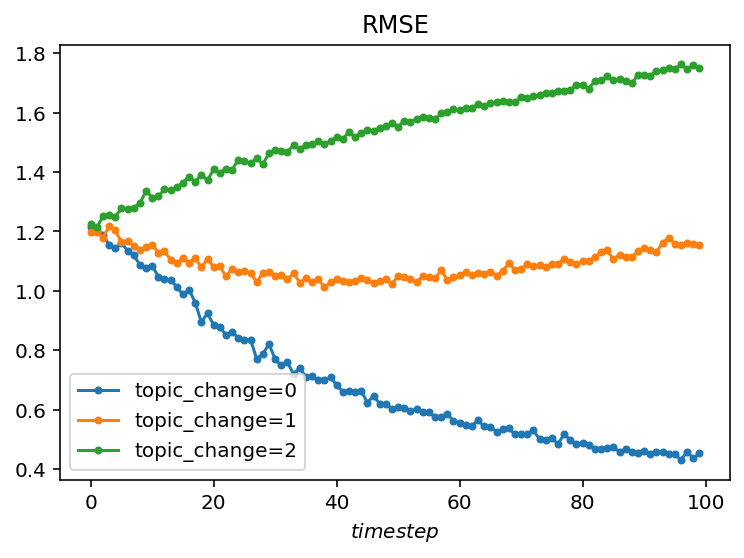

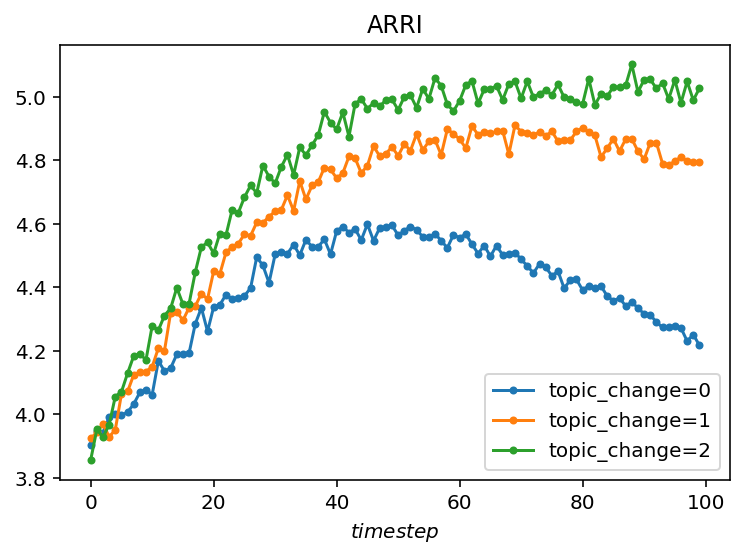

In [14]:
for k, v in res.items():
  plot_graphs(*list(v.values()), title=k, legend=True, label=['topic_change=0','topic_change=1','topic_change=2'], show=True, save=True)